In [1]:
# imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
%matplotlib inline

# Feature Extraction functions

In [2]:
def read_images(path):
    images = glob.glob(path)
    ret = []
    for image in images:
        ret.append(image)
        
    return ret

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32), nbins=32, bins_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
#         print(file)
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        bin_features = bin_spatial(feature_image, size=spatial_size)
        color_hist_features = color_hist(feature_image, nbins=nbins, bins_range=bins_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features, bin_features, color_hist_features)))
    # Return list of feature vectors
    return features

def extract_test_feature(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32), nbins=32, bins_range=(0, 256)):
    
    features = []
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
        
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
#         print(orient, pix_per_cell, cell_per_block)
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    
    bin_features = bin_spatial(feature_image, size=spatial_size)
    color_hist_features = color_hist(feature_image, nbins=nbins, bins_range=bins_range)
    # Append the new feature vector to the features list
#     print(len(hog_features))
    features.append(np.concatenate((hog_features, bin_features, color_hist_features)))
    return np.ravel(features).astype(np.float64)

In [5]:
car_paths = ['vehicles/GTI_Far/*', 'vehicles/GTI_Left/*', 'vehicles/GTI_MiddleClose/*', 'vehicles/GTI_Right/*', 'vehicles/KITTI_extracted/*']
noncar_paths = ['non-vehicles/Extras/*', 'non-vehicles/GTI/*']

In [6]:
def read_images_from_path(paths):
    images = []
    for path in paths:
        images = images + read_images(path)
        
    return images

car_images = read_images_from_path(car_paths)
noncar_images = read_images_from_path(noncar_paths)
# print(car_images)

In [7]:
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size=(16, 16)
nbins=32
bins_range=(0, 256)

car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                               nbins=nbins, bins_range=bins_range)
print(len(car_features[0]))
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                               nbins=nbins, bins_range=bins_range)
print(len(car_features))

2432
8792


In [8]:
print(len(notcar_features[0]))
# print(notcar_features)

2432


In [9]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
# print(X)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [10]:
print(len(scaled_X))
print(len(y))

17760
17760


In [11]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
8.31 Seconds to train SVC...


non-vehicles/Extras/extra1.png
0.966497747748
2432


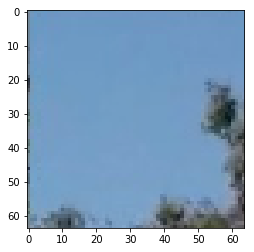

In [12]:
print(noncar_images[0])
car = mpimg.imread(noncar_images[0])
# print(car)
plt.imshow(car)
pred = svc.score(X_test, y_test)
print(pred)
print(len(X_test[0]))

In [13]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

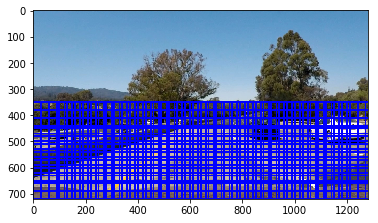

In [14]:
test_images = read_images('test_images/*')
test_image = mpimg.imread(test_images[0])
window_list = slide_window(test_image, xy_window=(100, 100), y_start_stop=[350, None], xy_overlap=(0.7, 0.7))
box_image = draw_boxes(test_image, window_list)
plt.imshow(box_image)

In [19]:
def classify(img, bboxes):
    predict_car_list = []
    for bbox in bboxes:
#         print(bbox[1][0])
        test_img = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
#         print(bbox)
#         print(test_img)
        test_img = cv2.resize(test_img, (64, 64))
        features = extract_test_feature(test_img, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                               nbins=nbins, bins_range=bins_range)
#         print(len(features))
#         features = features.reshape(-1, 1)
#         X_scaler = StandardScaler().fit(features.reshape(-1, 1))
        scaled_feat = X_scaler.transform(features)
#         print(len(scaled_feat))
        prediction = svc.predict(scaled_feat)
        if prediction[0] == 1:
            predict_car_list.append(bbox)
        
    return predict_car_list

/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

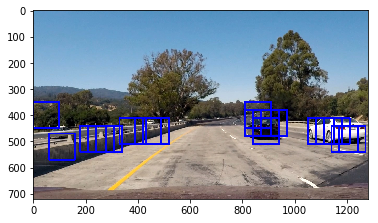

In [20]:
car_boxes = classify(test_image, window_list)
prediction_car_image = draw_boxes(test_image, car_boxes)
plt.imshow(prediction_car_image)

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


4 cars found


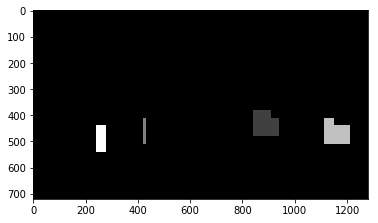

In [28]:
heatmap = np.zeros_like(test_image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, car_boxes)
heatmap = apply_threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

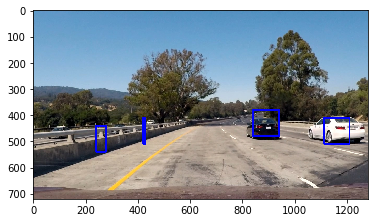

In [29]:
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
# Display the image
plt.imshow(draw_img)

In [34]:
# heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
def process_image(image):
    window_list = slide_window(test_image, xy_window=(64, 64), y_start_stop=[350, None], xy_overlap=(0.7, 0.7))
    window_list += slide_window(test_image, xy_window=(100, 100), y_start_stop=[350, None], xy_overlap=(0.7, 0.7))
    window_list += slide_window(test_image, xy_window=(128, 128), y_start_stop=[350, None], xy_overlap=(0.7, 0.7))
#     window_list += slide_window(test_image, xy_window=(256, 256), y_start_stop=[350, None])
    car_boxes = classify(image, window_list)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, car_boxes)
    heatmap = apply_threshold(heatmap, 4)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

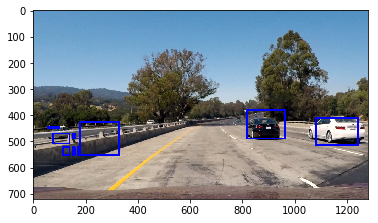

In [35]:
final_image = process_image(test_image)
plt.imshow(final_image)

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
white_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [02:01<00:03,  3.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 2min, sys: 463 ms, total: 2min 1s
Wall time: 2min 3s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))